In [1]:
pip install ipymarkup

  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=515a4ee218b9bcc63a619df20ee6feb04e1fecedd416f3cdc38845e4d175c645
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 
import os
import torch
from torch import nn
import re
from tqdm import tqdm, tqdm_notebook
from torch.optim import Adam, AdamW
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
pd.options.mode.chained_assignment = None  # default='warn'
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, accuracy_score
from ipymarkup import show_span_box_markup

In [3]:
# Для версии Андрея
# PATH1 = '/kaggle/input/rurebustraindata/train_part_1/train_part_1'
# PATH2 = '/kaggle/input/rurebustraindata/train_part_2/train_part_2'
# PATH3 = '/kaggle/input/rurebustraindata/train_part_3/train_part_3'
# Для версии Гарри и Тани
PATH1 = '/kaggle/input/rurebus-train-data/train_part_1/train_part_1'
PATH2 = '/kaggle/input/rurebus-train-data/train_part_2/train_part_2'
PATH3 = '/kaggle/input/rurebus-train-data/train_part_3/train_part_3'
PATH4 = '/kaggle/input/rurebus-train-data/test_ner_only' #чтобы все ок было надо обновить датасет до последней версии
# имена сущностей
NAMES = ['BIN', 'SOC', 'MET', 'CMP', 'ECO', 'INST', 'ACT', 'QUA']
# тэги для разметки
TAG = ['B-bin', 'I-bin', 'B-soc','I-soc','B-met', 'I-met','B-cmp','I-cmp','B-eco', 'I-eco','B-inst','I-inst','B-act','I-act','B-qua','I-qua']

В тесте присутствует множество тестов разбитых по частям (part_1, part_2 и тд.). Они представляют собой логически целое однако среди нет переносов в аннотациях. 
В аннотации присутствует следующая информация: именование сущности, ее класс а также местоположение в тексте (посимвольное).
Что касается отношений то дается информация о номере сущности и классе связи.
Для дальнейшем работы необходимо понять какой формат входных данных нужен для cnn lstm 


In [4]:
# подготовка данных для обучения
def make_data(lst,path):        
    res_df = pd.DataFrame(columns = ['word', 'tag'])
    with tqdm(desc="n", total=len(lst)) as pbar_outer:
        for item in lst:
            df1 = make_ann(item,path)
            df2 = make_text(item, df1,path)
            res_df = pd.concat([res_df, df2], ignore_index=True)
            pbar_outer.update(1)
    return res_df


# продготовка аннотаций
def make_ann(file,path):
    # открываю файл
    ann_df = pd.read_csv(path+'/'+file+'.ann', sep='\t', engine='python', header=None, on_bad_lines='skip') # здесь добавлено скипанье плохих строк(если например столбцов 6, а в трок только 4), наверно это не оч хорошо надо что-то придумать
    # нормальные названия для столбцов
    ann_df.rename(columns = {1:'class', 2:'words'}, inplace = True )
    # разделяю в разные столбцы классы и координаты
    ann_df.insert(2, 'coords' , ann_df['class'])
    ann_df['class'] = ann_df['class'].apply(lambda x: x.split(" ")[0])
    ann_df['coords'] = ann_df['coords'].apply(lambda x: x.split(" ")[1:])
    # удаляю нафиг строки с отношениями
    ann_df = ann_df.dropna()
    ann_df.reset_index(drop= True , inplace= True )
    # для удобства
    ann_df.insert(2, 'coords1' , ann_df['coords'])
    ann_df['coords1'] = ann_df['coords1'].apply(lambda x: int(x[0]))
    ann_df['words'] = ann_df['words'].apply(lambda x: my_split(x.split(" ")))
    ann_df['words'] = ann_df['words'].apply(lambda x: del_all(x))
    ann_df['words'] = ann_df['words'].apply(lambda x: [item.strip() for item in x if item not in ['','»', '«',':',' ']])
    ann_df = ann_df.sort_values(by='coords1')
    ann_df.reset_index(drop= True , inplace= True )
    return ann_df


# разметка
def make_text(file, df,path):
    # открываем файл и записываем его в dataframe
    with open(path+'/'+file+'.txt') as f:
        lines = f.readlines()
    text_df = pd.DataFrame({'word':lines})
    # считаем длины строк для удобства дальнейшей разметки
    text_df.insert(1, 'len' , text_df['word'].copy())
    text_df['len'] = text_df['len'].apply(lambda x: len(x)) # считаем длину строки
    new_lens = [text_df['len'][0]] # считаем длину предыдущих строк + длина новой строки
    for i in range(1, len(list(text_df['len']))):
        new_lens.append(sum(list(text_df['len'])[:i+1]))
    text_df.insert(2, 'new_len' , new_lens)
    # добавляем столбец для разметки
    text_df.insert(3, 'tag', 0)
    # удаляем \n
    text_df['word'] = text_df['word'].apply(lambda x: re.split('\n',x)[0])
    #удаляем строрки с []
    idx = [i for i in range(len(text_df)) if len(text_df['word'][i])==0]
    text_df = text_df.drop(index=idx)
    text_df.reset_index(drop = True, inplace= True)
    # делаем разметку
    # находим индекс строки для каждой аннотации
    df = find_rows(text_df, df)
#     print(df.head(5))
    # преобразовываем строку в массив
    text_df['word'] = text_df['word'].apply(lambda x: my_split([item for item in re.split(' ',x) if item != '']))
    text_df['word'] = text_df['word'].apply(lambda x: del_all(x))
    text_df['word'] = text_df['word'].apply(lambda x: [item.strip() for item in x if item not in ['',' ']])
    # момент разметки
    text_df = make_markup(text_df, df)
    text_df = last_changes(text_df)
#     # удаляем лишнее
    del text_df['len']
    del text_df['new_len']
    text_df['word'] = text_df['word'].apply(lambda x: [item.lower() for item in x if item not in ['',' ']])
    idx = [i for i in range(len(text_df)) if len(text_df['word'][i])==0]
    text_df = text_df.drop(index=idx)
    text_df.reset_index(drop = True, inplace= True)
    return text_df


# отделяем все что можно
def my_split(lst):
    for k in range(3):
        for i in range(len(lst)-1,-1,-1):
            if lst[i] in ['',' ']:
                lst.pop(i)
            else:
                lst[i] = lst[i].replace('\xa0', ' ')
                lst[i] = lst[i].replace('\t', ' ')
                lst[i]=lst[i].replace('………………','')
                lst[i]=lst[i].replace('………','')
                lst[i] = lst[i].replace('……','')
                idx = []
                lens = len(lst[i])
                for item in ['+', ')', '»',';','.',',', '"','(', '«',':',' ', '-\t','\\', '/','”','“','-','–','_________','*','№','%']:
                     idx.append(lst[i].find(item))
                for item in ['\xa0','"','.']:
                    if lst[i].endswith(item) and lens-1 not in idx:
                        idx.append(lens-1)                    
                idx.sort(reverse=True)
                for item in idx:
                    if item!=-1 and item!=0:
                        lst.insert(i+1, lst[i][item])
                        lst.insert(i+2, lst[i][item+1:])
                        lst[i] = lst[i][:item]
                    elif item!=-1 and item == 0:
                        lst.insert(i+1, lst[i][item+1:])
                        lst[i] = lst[i][item]
                    elif item!= -1 and item == lens-1:
                        lst.insert(i+1, lst[i][item])
                        lst[i] = lst[i][:item] 
    return lst


def del_all(lst):
    for i in range(len(lst)-1,-1,-1):
        split = lst[i]
        split = split.split(' ')
        if len(split) >1:
            for j in range(len(split)):
                lst.insert(i+1+j, split[j])
            lst.pop(i)
    return lst


# обработка строк без сущностей и оставшихся слов
def last_changes(df):
    for i in range(len(df)):
        if df['tag'][i] == 0:
            df['tag'][i] = ['O'] * len(df['word'][i])
        else:
#             df['tag'][i] = my_split(df['tag'][i])
            llst = []
            for item in df['tag'][i]:
                if item in TAG:
                    llst.append(item)
                else:
                    llst.append('O')
            df['tag'][i] = llst
        assert (len(df['word'][i]) == len(df['tag'][i]))
    return df

# находим индекс строки для каждой аннотации
def find_rows(txt_df, ann_df):
    ann_df.insert(4, 'idx' , 0)
    for i in range(len(ann_df)):
        for j in range(len(txt_df)):
            start = txt_df['new_len'][j]-txt_df['len'][j]
            end = txt_df['new_len'][j]
            if int(ann_df['coords'][i][0]) in np.arange(start, end):
                ann_df['idx'][i] = j
                break
            else:
                pass
    return ann_df
    
# основная часть разметки
def make_markup(text_df, ann_df):
    for i in range(len(ann_df)):
        words_count = len(ann_df['words'][i])
        lens = [len(item) for item in ann_df['words'][i]] 
        row = text_df.iloc[[ann_df['idx'][i]]]
#         print(row['word'].item())
        if row['tag'].item() == 0:
                        text_df['tag'][ann_df['idx'][i]] = text_df['word'][ann_df['idx'][i]].copy()
                        row['tag'] = row['word']
        for k in range(words_count):
                if k == 0:
                    idx = (row['tag'].item()).index(ann_df['words'][i][k])
                    text_df['tag'][ann_df['idx'][i]][idx] = 'B-'+ ann_df['class'][i].lower()
                else:
                    idx = row['tag'].item().index(ann_df['words'][i][k])
                    text_df['tag'][ann_df['idx'][i]][idx] = 'I-'+ ann_df['class'][i].lower()
    return text_df

In [5]:
# список всех файлов для обучения
data_lst = list(set([item[:-4] for item in os.listdir(PATH1)]))
data_lst.remove('.stats_c')
train_df = make_data(data_lst, PATH1)
train_df

n: 100%|██████████| 99/99 [01:08<00:00,  1.45it/s]


,word,tag
0,"[ш, у, ö, м]","[O, O, O, O]"
1,"[п, о, с, т, а, н, о, в, л, е, н, и, е]","[O, O, O, O, O, O, O, O, O, O, O, O, O]"
2,"[29, марта, 2019, г, ., №, 158]","[O, O, O, O, O, O, O]"
3,"[с, ., айкино]","[O, O, O]"
4,"[о, внесении, изменений, в, постановление, адм...","[O, B-bin, O, O, O, B-inst, I-inst, O, I-inst,..."
...,...,...
8468,"[установить, ,, что, ассигнования, ,, предусмо...","[B-bin, O, O, B-eco, O, O, O, B-eco, O, O, O, ..."
8469,"[15, .]","[O, O]"
8470,"[установить, размер, резервного, фонда, на, 20...","[B-bin, B-met, I-met, I-met, O, O, O, O, O, O,..."
8471,"[16, .]","[O, O]"


In [6]:
#файлы для валидации
data_lst = list(set([item[:-4] for item in os.listdir(PATH2)]))
data_lst = data_lst[0]
val_df = make_data([data_lst], PATH2)
val_df

n: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


,word,tag
0,"[приложение, №, 1]","[O, O, O]"
1,"[к, постановлению, администрации, малопривалов...","[O, O, O, O]"
2,"[сельского, поселения]","[O, O]"
3,"[от, 21, ., 12, ., 2018, №, 74]","[O, O, O, O, O, O, O, O]"
4,"[муниципальная, программа]","[O, O]"
...,...,...
87,"[к, числу, социально, -, экономических, послед...","[O, O, O, O, O, O, B-bin, O, B-bin, B-eco, I-e..."
88,"[повышение, уровня, и, улучшение, социальных, ...","[B-cmp, B-met, O, B-cmp, B-soc, I-soc, I-soc, ..."
89,"[улучшение, транспортного, обслуживания, насел...","[B-cmp, B-soc, I-soc, O, O, O, O, O, O]"
90,"[снижение, негативного, влияния, дорожно, -, т...","[B-cmp, B-qua, O, B-eco, I-eco, I-eco, I-eco, ..."


In [7]:
vocab = build_vocab_from_iterator(train_df['word'], min_freq=1, specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])
vocab_lables = build_vocab_from_iterator(train_df['tag'], min_freq=1)

In [8]:
vocab(train_df['word'][0])

[13519, 313, 7946, 592]

In [9]:
def make_tl(df):
    tokens = []
    lables = []
    max_len = 0
    for ind in df.index:
        tokens.append(vocab(df['word'][ind]))
        lables.append(vocab_lables(df['tag'][ind]))
        if len(df['word'][ind]) > max_len:
            max_len = len(df['word'][ind])
    df['tokens'] = tokens
    df['lables'] = lables
    return df,max_len


def make_pad(df):
    list_sent = []
    list_labels = []
    for ind in df.index:
        list_sent.append(df['tokens'][ind])
        list_labels.append(df['lables'][ind])
    padded_sent = pad_sequences(list_sent)
    padded_labels = pad_sequences(list_labels)
    print(padded_sent.shape)
    padd_df = pd.DataFrame(columns = ['sentence', 'labels'])
    padd_df['sentence'] = pd.Series(padded_sent.tolist())
    padd_df['labels'] = pd.Series(padded_labels.tolist())
    return padd_df

In [10]:
train_df,max_len1 = make_tl(train_df)
val_df,max_len2 = make_tl(val_df)
train_df

,word,tag,tokens,lables
0,"[ш, у, ö, м]","[O, O, O, O]","[13519, 313, 7946, 592]","[0, 0, 0, 0]"
1,"[п, о, с, т, а, н, о, в, л, е, н, и, е]","[O, O, O, O, O, O, O, O, O, O, O, O, O]","[135, 34, 13, 290, 57, 1060, 34, 4, 1739, 823,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[29, марта, 2019, г, ., №, 158]","[O, O, O, O, O, O, O]","[607, 1119, 80, 48, 1, 25, 4011]","[0, 0, 0, 0, 0, 0, 0]"
3,"[с, ., айкино]","[O, O, O]","[13, 1, 8014]","[0, 0, 0]"
4,"[о, внесении, изменений, в, постановление, адм...","[O, B-bin, O, O, O, B-inst, I-inst, O, I-inst,...","[34, 713, 424, 4, 268, 45, 196, 10, 291, 5, 32...","[0, 4, 0, 0, 0, 12, 6, 0, 6, 6, 6, 0, 0, 0, 0,..."
...,...,...,...,...
8468,"[установить, ,, что, ассигнования, ,, предусмо...","[B-bin, O, O, B-eco, O, O, O, B-eco, O, O, O, ...","[1678, 2, 123, 2853, 2, 1772, 4, 793, 6, 80, 6...","[4, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, ..."
8469,"[15, .]","[O, O]","[275, 1]","[0, 0]"
8470,"[установить, размер, резервного, фонда, на, 20...","[B-bin, B-met, I-met, I-met, O, O, O, O, O, O,...","[1678, 3810, 3823, 400, 6, 80, 68, 4, 762, 303...","[4, 8, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8471,"[16, .]","[O, O]","[569, 1]","[0, 0]"


In [11]:
print(max_len1, ' ',max_len2)

302   90


In [12]:
# делаем паддинг 
train_df = make_pad(train_df)
val_df = make_pad(val_df)
train_df

(8473, 302)
(92, 90)


,sentence,labels
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
8468,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8469,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8470,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8471,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
print(len(train_df['sentence'][4]),len(val_df['sentence'][4]))

302 90


In [14]:
def one_hot(x: np.ndarray, vocab_len: int) -> np.ndarray:
    """
    Args:
        x - одномерный массив значений словаря
        vocab_len - длина словаря
    Выход:
        двумерный массив encoded, где encoded[i] - результат one hot кодирования x[i]
    """
    encoded = np.zeros((len(x), vocab_len))
    for i in range(len(x)):
        encoded[i][x[i]] = 1
    return encoded

text_vocab_len = len(vocab)
target_vocab_len = len(vocab_lables)

class TokenDataset(torch.utils.data.Dataset):
    def __init__(self, data, text_vocab_len = text_vocab_len, target_vocab_len = target_vocab_len, classes = None,
                 transform=None, target_transform=None):
        self.data = data
        self.sequence_len = len(data.iloc[0][0])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        tokens, tag = self.data.iloc[idx]
        return torch.Tensor(tokens).int(), torch.Tensor(one_hot(tag, target_vocab_len))
        # return torch.Tensor(tokens).int(), torch.Tensor(tag)


In [15]:
datasets = {
    'train': TokenDataset(train_df),
    'val': TokenDataset(val_df)
}

In [16]:
dataloader = {
    'train':
    torch.utils.data.DataLoader(datasets['train'],
                                batch_size=16,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'val':
    torch.utils.data.DataLoader(datasets['val'],
                                batch_size=16,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [18]:
class CNN_LSTM(nn.Module):
    def __init__(self, vocab_size, n_classes, embedding_dim=250, hidden_size = 32, filters=((2, 10), (3, 8))):
        super().__init__()
        
        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=200, kernel_size=3,padding=1)
        self.pool1 = nn.MaxPool1d(2)
        input_size = 100
        self.hidden_size = hidden_size
        self.lstm_layer = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, n_classes)
        outputs = []

    def forward(self, inputs):
        projections = self.embeddings_layer.forward(inputs) 
        projections = projections.transpose(1, 2)
        projections = self.conv1(projections)
        projections = projections.transpose(1, 2)
        projections = self.pool1(projections)
        output, (final_hidden_state, final_cell_state) = self.lstm_layer(projections)
        output = output.reshape(-1, self.hidden_size)
        output = self.fc(output)
        return output


In [19]:
def train_model(model, criterion, optimizer, num_epochs=3):
    all_true_labels = []
    all_preds = []
    inputs_str = []
    loss_list = {'train' : [], 'val':[]}
    acc_list = {'train' : [], 'val':[]}
    f1_list = {'train' : [], 'val':[]}
#     lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                    step_size=10,
#                                                    gamma=0.2)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                print('start train')
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            all_true_labels = []
            all_preds = []
            inputs_str = []
            for inputs, labels in tqdm(dataloader[phase]):
                batch_size, n_words, n_classes = labels.shape
                labels = labels.reshape(-1, n_classes).to(device)
                outputs = model(inputs.to(device))
                
                loss = criterion(outputs, labels)
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() #* inputs.size(0)
                _, labels = torch.max(labels, 1)

                all_true_labels.extend(labels.tolist())
                all_preds.extend(preds.tolist())
            epoch_loss = running_loss /len(dataloader[phase])
            epoch_acc = accuracy_score(all_preds, all_true_labels)
            epoch_f1 = f1_score(all_preds, all_true_labels, average='macro')
#             lr_scheduler.step()  
            print('{} loss: {:.4f}, acc: {:.4f}, f1: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc,
                                                        epoch_f1            
                                                        ))
            loss_list[phase].append(epoch_loss)
            acc_list[phase].append(epoch_acc.tolist())
            f1_list[phase].append(epoch_f1.tolist())
    return all_true_labels, all_preds, inputs_str, loss_list, acc_list, f1_list

In [20]:
n_classes = len(vocab_lables)
model = CNN_LSTM(len(vocab), n_classes = n_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr = 3e-4)

In [21]:
epox_num = 15
all_true_labels, all_preds, inputs_str, loss, acc, f1 = train_model(model, criterion, optimizer, epox_num)

Epoch 1/15
----------
start train


100%|██████████| 530/530 [01:25<00:00,  6.22it/s]


train loss: 0.2787, acc: 0.9730, f1: 0.0596


100%|██████████| 6/6 [00:00<00:00, 48.73it/s]


val loss: 0.3566, acc: 0.9139, f1: 0.0562
Epoch 2/15
----------
start train


100%|██████████| 530/530 [01:21<00:00,  6.53it/s]


train loss: 0.0875, acc: 0.9791, f1: 0.0654


100%|██████████| 6/6 [00:00<00:00, 54.47it/s]


val loss: 0.3152, acc: 0.9151, f1: 0.0620
Epoch 3/15
----------
start train


100%|██████████| 530/530 [01:19<00:00,  6.66it/s]


train loss: 0.0742, acc: 0.9801, f1: 0.0893


100%|██████████| 6/6 [00:00<00:00, 51.56it/s]


val loss: 0.2984, acc: 0.9193, f1: 0.0841
Epoch 4/15
----------
start train


100%|██████████| 530/530 [01:20<00:00,  6.59it/s]


train loss: 0.0665, acc: 0.9814, f1: 0.1254


100%|██████████| 6/6 [00:00<00:00, 51.51it/s]


val loss: 0.2845, acc: 0.9248, f1: 0.1226
Epoch 5/15
----------
start train


100%|██████████| 530/530 [01:18<00:00,  6.78it/s]


train loss: 0.0598, acc: 0.9832, f1: 0.1765


100%|██████████| 6/6 [00:00<00:00, 54.82it/s]


val loss: 0.2839, acc: 0.9254, f1: 0.1323
Epoch 6/15
----------
start train


100%|██████████| 530/530 [01:19<00:00,  6.66it/s]


train loss: 0.0535, acc: 0.9848, f1: 0.2162


100%|██████████| 6/6 [00:00<00:00, 57.59it/s]


val loss: 0.2663, acc: 0.9301, f1: 0.1489
Epoch 7/15
----------
start train


100%|██████████| 530/530 [01:20<00:00,  6.56it/s]


train loss: 0.0478, acc: 0.9863, f1: 0.2686


100%|██████████| 6/6 [00:00<00:00, 48.29it/s]


val loss: 0.2603, acc: 0.9339, f1: 0.1860
Epoch 8/15
----------
start train


100%|██████████| 530/530 [01:21<00:00,  6.53it/s]


train loss: 0.0426, acc: 0.9878, f1: 0.3352


100%|██████████| 6/6 [00:00<00:00, 56.20it/s]


val loss: 0.2514, acc: 0.9368, f1: 0.2169
Epoch 9/15
----------
start train


100%|██████████| 530/530 [01:20<00:00,  6.62it/s]


train loss: 0.0381, acc: 0.9891, f1: 0.3972


100%|██████████| 6/6 [00:00<00:00, 53.50it/s]


val loss: 0.2537, acc: 0.9396, f1: 0.2695
Epoch 10/15
----------
start train


100%|██████████| 530/530 [01:19<00:00,  6.69it/s]


train loss: 0.0339, acc: 0.9904, f1: 0.4567


100%|██████████| 6/6 [00:00<00:00, 60.56it/s]


val loss: 0.2667, acc: 0.9394, f1: 0.2992
Epoch 11/15
----------
start train


100%|██████████| 530/530 [01:18<00:00,  6.76it/s]


train loss: 0.0305, acc: 0.9914, f1: 0.5120


100%|██████████| 6/6 [00:00<00:00, 60.69it/s]


val loss: 0.2669, acc: 0.9378, f1: 0.2660
Epoch 12/15
----------
start train


100%|██████████| 530/530 [01:19<00:00,  6.66it/s]


train loss: 0.0274, acc: 0.9923, f1: 0.5549


100%|██████████| 6/6 [00:00<00:00, 57.73it/s]


val loss: 0.2701, acc: 0.9394, f1: 0.2990
Epoch 13/15
----------
start train


100%|██████████| 530/530 [01:19<00:00,  6.68it/s]


train loss: 0.0248, acc: 0.9930, f1: 0.5887


100%|██████████| 6/6 [00:00<00:00, 60.97it/s]


val loss: 0.2691, acc: 0.9407, f1: 0.3604
Epoch 14/15
----------
start train


100%|██████████| 530/530 [01:18<00:00,  6.77it/s]


train loss: 0.0226, acc: 0.9937, f1: 0.6246


100%|██████████| 6/6 [00:00<00:00, 57.22it/s]


val loss: 0.2641, acc: 0.9437, f1: 0.3834
Epoch 15/15
----------
start train


100%|██████████| 530/530 [01:17<00:00,  6.82it/s]


train loss: 0.0204, acc: 0.9942, f1: 0.6497


100%|██████████| 6/6 [00:00<00:00, 60.33it/s]

val loss: 0.2679, acc: 0.9436, f1: 0.3866


In [22]:
epox_list = [i for i in range(epox_num)]
def graf(loss, acc):
    
    fig, ax = plt.subplots(2, 3, figsize=(26, 13))
    ax[0, 0].plot(epox_list, loss['train'])
    ax[0, 0].set_title("Изменение потерь на обучающей выборке")
    ax[0, 1].plot(epox_list, acc['train'])
    ax[0, 1].set_title("Изменение точности на обучающей выборке")
    ax[0, 2].plot(epox_list, f1['train'])
    ax[0, 2].set_title("Изменение f1-score на обучающей выборке")
    ax[1, 0].plot(epox_list, loss['val'])
    ax[1, 0].set_title("Изменение потерь на валидационной выборке")
    ax[1, 1].plot(epox_list, acc['val'])
    ax[1, 1].set_title("Изменение точности на валидационной выборке")
    ax[1, 2].plot(epox_list, f1['val'])
    ax[1, 2].set_title("Изменение f1-score на валидационной выборке")
    plt.show()

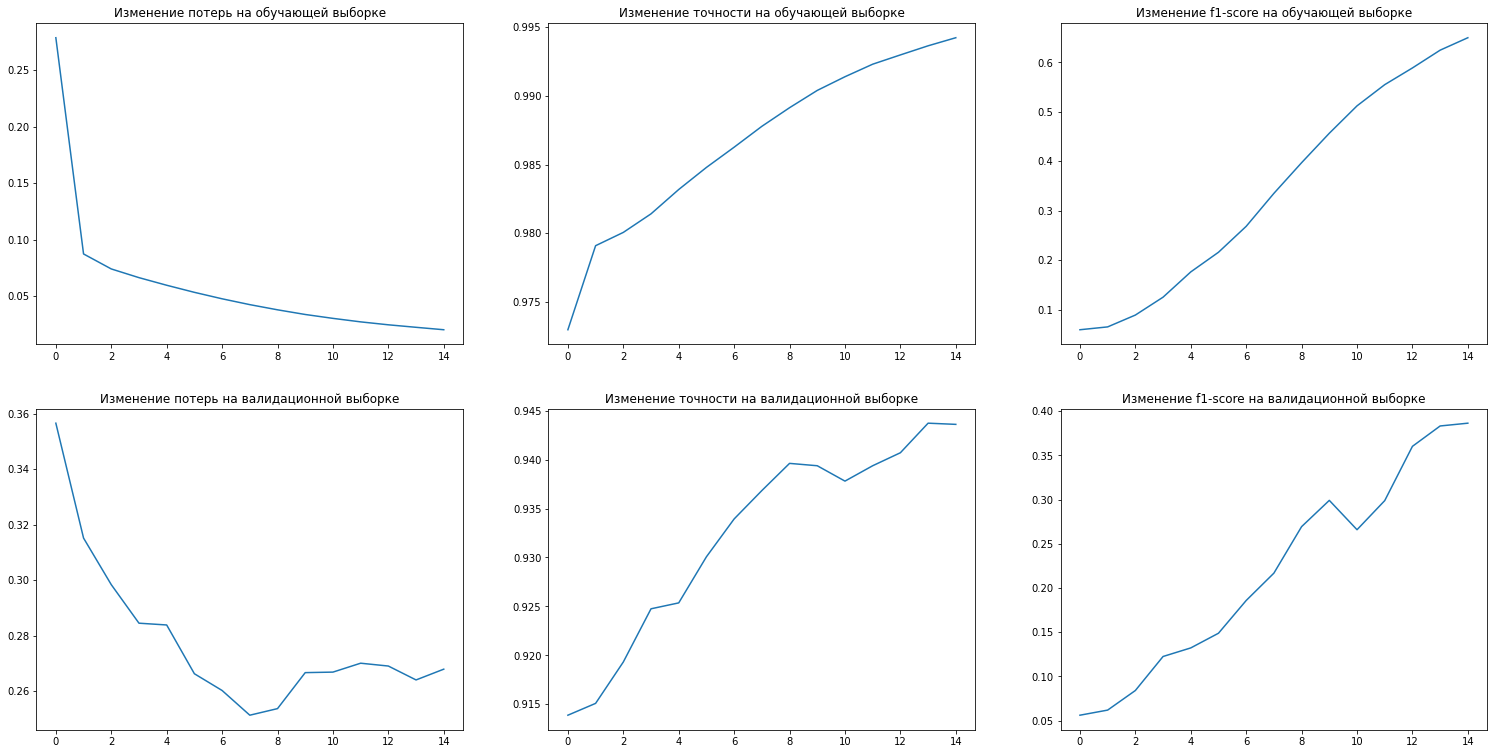

In [23]:
import matplotlib.pyplot as plt
graf(loss, acc)

In [24]:
def make_test(model,dataloader,dataset):
    all_true_labels = []
    all_preds = []
    inputs_str = []
    acc_list = []
    model.eval()
    for inputs, labels in tqdm(dataloader):
        batch_size, n_words, n_classes = labels.shape
        labels = labels.reshape(-1, n_classes).to(device)
        outputs = model(inputs.to(device))
        _, preds = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        all_true_labels.extend(labels.tolist())
        all_preds.extend(preds.tolist())
    epoch_acc = accuracy_score(all_preds, all_true_labels)
    epoch_f1 = f1_score(all_preds, all_true_labels, average='macro')
    print('acc: {:.4f}, f1: {:.4f}'.format(epoch_acc, epoch_f1))
    acc_list.append(epoch_acc.tolist())
    return all_true_labels,all_preds

In [25]:
data_lst = list(set([item[:-4] for item in os.listdir(PATH4)]))
data_lst.remove('31339221025603182330049_24_part_1')
data_lst.remove('31339131024502051716072_24_part_1')
data_lst.remove('31339251033301001216016_20_part_2')
data_lst.remove('31339011021101006981035_9_part_1')
data_lst.remove('31339011021100987258005_5_part_2')
data_lst.remove('31339011061672000026002_4_part_2')
data_lst.remove('31339011026200597103018_8_part_1')
data_lst.remove('31339201027002952877006_14_part_2')
test_df = make_data(data_lst[:100], PATH4)
test_df,max_len1 = make_tl(test_df)
test_df = make_pad(test_df)

n: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


(5953, 444)


In [26]:
dataset =  TokenDataset(test_df)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False, num_workers=0)
all_t,all_p = make_test(model,test_dataloader,dataset)

100%|██████████| 2977/2977 [01:35<00:00, 31.20it/s]


acc: 0.9884, f1: 0.3087


In [27]:
# убираем палдинги 
data = {'sentence': test_df['sentence'], 'real_cat': np.array_split(all_t, len(test_df['sentence'])), 'pred_cat':np.array_split(all_p, len(test_df['sentence']))}
df_test_see = pd.DataFrame(data)
for ind in df_test_see.index:
    sent = df_test_see['sentence'][ind]
    try:
        len_pad = sent.index(next(filter(lambda x: x!=0, sent)))
    except StopIteration:
        pass
    sent = sent[len_pad:]
    sent = vocab.lookup_tokens(sent)
    df_test_see.at[ind, 'sentence'] = sent 
    sent = df_test_see['real_cat'][ind]
    sent = sent[len_pad:]
    sent = vocab_lables.lookup_tokens(sent)
    df_test_see.at[ind, 'real_cat'] = sent 
    sent = df_test_see['pred_cat'][ind]
    sent = sent[len_pad:]
    sent = vocab_lables.lookup_tokens(sent)
    df_test_see.at[ind, 'pred_cat'] = sent 
df_test_see

,sentence,real_cat,pred_cat
0,"[ожидается, ,, что, в, рамках, мероприятия, №,...","[O, O, O, B-met, O, O, O, O, O, O, O, B-met, I...","[O, O, O, O, O, O, O, O, O, O, O, B-eco, I-met..."
1,"[развитие, системы, <UNK>, ,, организация, уда...","[B-cmp, B-eco, I-eco, O, B-bin, B-eco, I-eco, ...","[B-bin, O, O, O, B-bin, B-act, B-act, O, O, O,..."
2,"[ожидается, ,, что, в, рамках, мероприятия, №,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-m...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[развитие, системы, <UNK>, придомовых, террито...","[B-cmp, B-eco, I-eco, I-eco, I-eco, O, B-bin, ...","[B-bin, O, O, O, I-eco, O, B-bin, B-act, I-act..."
4,"[ожидается, ,, что, в, рамках, мероприятия, №,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-m...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-m..."
...,...,...,...
5948,[перечень],[O],[O]
5949,"[показателей, цели, и, задач, подпрограммы, и,...","[O, O, O, O, O, O, O, O, O, B-act, O]","[B-met, O, O, O, O, O, O, O, O, O, O]"
5950,"[по, показателям, и, методике, их, расчета]","[O, O, O, O, O, O]","[O, O, O, O, O, O]"
5951,"[6, ., 3, ., перечень, основных, мероприятий]","[O, O, O, O, O, O, O]","[O, O, O, O, O, O, O]"


In [28]:
def make_show(row,lbl):
    spans = []
    coords = 0
    c1 = 0
    c2 = 0
    tag = ''
    text = ''
    last = 0
    for i in range(len(row)):
        text += row[i]+' '
        if lbl[i] in TAG:
            if 'B-' in lbl[i]:
                c1 = coords
                c2 = coords + len(row[i])
                tag = lbl[i][2:].upper()
                coords+=1+len(row[i])
            elif 'I-' in lbl[i]:
                c2+=1+len(row[i])
                coords+=1+len(row[i])
        elif lbl[i] =='O':
            coords += len(row[i])+1
        if (c1,c2,tag) !=(0, 0, ''):
            if last == c1:
                spans = spans[:-1]
            spans.append((c1,c2,tag))
            last = c1
    return text, spans

In [30]:
row_idx = 3
row = df_test_see['sentence'][row_idx]
true_lbl = df_test_see['real_cat'][row_idx]
pred_lbl = df_test_see['pred_cat'][row_idx]
text,spans1 = make_show(row,true_lbl)
_,spans2 = make_show(row,pred_lbl)
print('true:')
show_span_box_markup(text, spans1)
print('pred:')
show_span_box_markup(text, spans2)

true:


pred:
